In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt
from Scripts import reverse_preprocessing_func as rv
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from Scripts import to_stationary as ts
from Scripts import dir_functions
from Scripts import metrics_plotting as mp
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import GridSearchCV, ParameterGrid


import warnings
warnings.filterwarnings("ignore")

d:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Import Data

In [2]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')



# Split into train and test 

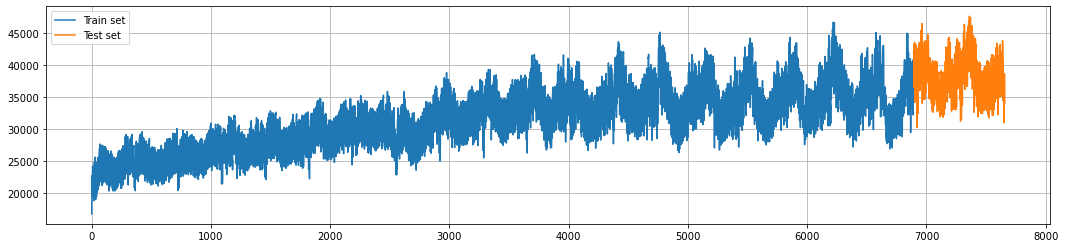

In [3]:
# split train and test data

TEST_SIZE = 0.1

df_train = data[:-round(TEST_SIZE*len(data))]
df_test = data[-round(TEST_SIZE*len(data)):]

plt.figure(figsize=(18,4))
plt.plot(df_train['carga'])
plt.plot(df_test['carga'])
plt.legend(['Train set', 'Test set'])
plt.grid()
plt.show()


In [16]:
params = {
    'p' : range(9,13),
    'q' : range(9,13),
    'd' : [0,1]
}

params_grid = ParameterGrid(params)
len(params_grid)

32

# Running ARIMA

In [17]:
# Grid search for p=[1,...,12], d=[0,1], q=[1,...,12]

df_test_norm = ts.normalize(df_test)
df_train_norm = ts.normalize(df_train)

best_error = np.Inf
best_params = params_grid[0]
all_preds = []

for param in params_grid:
    p = param['p']
    d = param['d']
    q = param['q']
    model = ARIMA(df_train_norm['carga'], order=(p,d,q))
    trained_model = model.fit()


    data_norm = pd.concat([df_train_norm, df_test_norm], axis=0).reset_index().drop('index', axis=1)

    # Forecasts entire test set
    preds=[]
    for new_value in df_test_norm.carga.values:
        preds.append(trained_model.forecast(1))
        trained_model = trained_model.append([new_value], refit=False)
    all_preds.append(preds)
        
    df_pred_norm = pd.DataFrame({'data': df_test.data, 'carga': preds})
    metrics = mp.calc_metrics(df_test_norm,df_pred_norm)
    mse = metrics['mse']
    if mse < best_error:
        best_params = param
        best_error = mse
    print(f'Params: {param}, Error = {mse}')

Params: {'d': 0, 'p': 9, 'q': 9}, Error = 0.12427165634909042
Params: {'d': 0, 'p': 9, 'q': 10}, Error = 0.12303258409437577
Params: {'d': 0, 'p': 9, 'q': 11}, Error = 0.12174159435089625
Params: {'d': 0, 'p': 9, 'q': 12}, Error = 0.12203317403324444
Params: {'d': 0, 'p': 10, 'q': 9}, Error = 0.12352665638398636
Params: {'d': 0, 'p': 10, 'q': 10}, Error = 0.12229905917132661
Params: {'d': 0, 'p': 10, 'q': 11}, Error = 0.12164750723491137
Params: {'d': 0, 'p': 10, 'q': 12}, Error = 0.12319535396410097
Params: {'d': 0, 'p': 11, 'q': 9}, Error = 0.12296299444130149
Params: {'d': 0, 'p': 11, 'q': 10}, Error = 0.12312967238267127
Params: {'d': 0, 'p': 11, 'q': 11}, Error = 0.12316632705022003
Params: {'d': 0, 'p': 11, 'q': 12}, Error = 0.12285527566252326
Params: {'d': 0, 'p': 12, 'q': 9}, Error = 0.13264866792841465
Params: {'d': 0, 'p': 12, 'q': 10}, Error = 0.12345887560074856
Params: {'d': 0, 'p': 12, 'q': 11}, Error = 0.12318065313342436
Params: {'d': 0, 'p': 12, 'q': 12}, Error = 0.12

In [18]:
best_params

{'d': 0, 'p': 10, 'q': 11}

In [19]:
model = ARIMA(df_train_norm['carga'], order=(best_params['p'],best_params['d'],best_params['q']))
trained_model = model.fit()

best lag: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000022F0A8AB3A0>
{'mse': 1348470.419834524, 'mape': 0.02046570117028772}


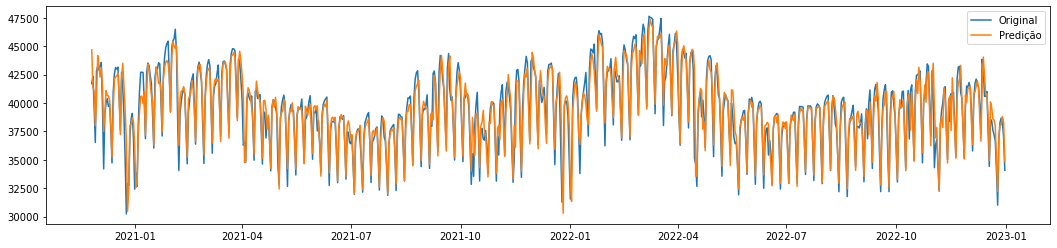

In [20]:
preds=[]
for new_value in df_test_norm.carga.values:
    preds.append(trained_model.forecast(1))
    trained_model = trained_model.append([new_value], refit=False)


df_pred_norm = pd.DataFrame({'data': df_test.data, 'carga': preds})
df_pred = rv.reverse_norm(df_test, df_pred_norm)

print(f'best lag: {trained_model}')
mp.compare_predictions(df_test, df_pred)
print(mp.calc_metrics(df_test, df_pred))